<h1><center>Pokemon: Entendendo a relação entre HP e outros status para cada criatura</center></h1>

O objetivo desse notebook é o de entender se existe alguma relação entre a variável de HP (Health Points, pontos de vida) e as outras demais variáveis para cada um dos 150 pokemons iniciais. Para entender a relação entre as variáveis são utilizados os métodos de análise regressiva linear simples e multipla. A ideia do notebook é a de fixar o conhecimento sobre análise regressiva, mas também ensinar e ajudar quem esteja tentando entender o tópico. 
A base de dados utilizada está disponível no Kaggle, pelo link: https://www.kaggle.com/datasets/rounakbanik/pokemon

<h3>1.  Importando as bibliotecas e preparando a base</h3>

In [20]:
#Importando Bibliotecas

%matplotlib inline
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype
import seaborn as sns
import statsmodels.api as sm
from statsmodels.sandbox.predict_functional import predict_functional
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot


In [21]:
warnings.filterwarnings('ignore')

In [22]:
df = pd.read_csv('Pokemon.csv')

Checando o head do dataframe e as colunas contidas nele

In [23]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


In [24]:
df.columns

Index(['abilities', 'against_bug', 'against_dark', 'against_dragon',
       'against_electric', 'against_fairy', 'against_fight', 'against_fire',
       'against_flying', 'against_ghost', 'against_grass', 'against_ground',
       'against_ice', 'against_normal', 'against_poison', 'against_psychic',
       'against_rock', 'against_steel', 'against_water', 'attack',
       'base_egg_steps', 'base_happiness', 'base_total', 'capture_rate',
       'classfication', 'defense', 'experience_growth', 'height_m', 'hp',
       'japanese_name', 'name', 'percentage_male', 'pokedex_number',
       'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg',
       'generation', 'is_legendary'],
      dtype='object')

Embora seja possível incorporar quaisquer variáveis dessas no modelo, o trabalho aqui vai trabalhar com algumas dessas. Assim, o primeiro passo é criar um novo dataframe, apenas com as variáveis possivelmente úteis ao trabalho. Isso facilita a exploração dos dados e agiliza a leitura do código

In [25]:
data_pokemon = df[['attack', 'capture_rate', 'classfication', 'defense', 'height_m', 'hp', 'name', 'sp_attack', 'sp_defense', 'speed', 'type1', 'type2', 'weight_kg', 'generation', 'is_legendary']]
data_pokemon.head()

,attack,capture_rate,classfication,defense,height_m,hp,name,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,49,45,Seed Pokémon,49,0.7,45,Bulbasaur,65,65,45,grass,poison,6.9,1,0
1,62,45,Seed Pokémon,63,1.0,60,Ivysaur,80,80,60,grass,poison,13.0,1,0
2,100,45,Seed Pokémon,123,2.0,80,Venusaur,122,120,80,grass,poison,100.0,1,0
3,52,45,Lizard Pokémon,43,0.6,39,Charmander,60,50,65,fire,NaN,8.5,1,0
4,64,45,Flame Pokémon,58,1.1,58,Charmeleon,80,65,80,fire,NaN,19.0,1,0


Antes de tudo, é necessário verificar se a base tem valores nulos. Os valores nulos serão preenchidos com o valor da mediana de toda a coluna, visando não atrapalhar a leitura dos dados

In [26]:
data_pokemon.isnull().sum()

attack             0
capture_rate       0
classfication      0
defense            0
height_m          20
hp                 0
name               0
sp_attack          0
sp_defense         0
speed              0
type1              0
type2            384
weight_kg         20
generation         0
is_legendary       0
dtype: int64

In [27]:
for col in data_pokemon[['height_m', 'weight_kg']]:
    data_pokemon[col].fillna(data_pokemon[col].median(), inplace=True)

In [28]:
data_pokemon.isnull().sum()

attack             0
capture_rate       0
classfication      0
defense            0
height_m           0
hp                 0
name               0
sp_attack          0
sp_defense         0
speed              0
type1              0
type2            384
weight_kg          0
generation         0
is_legendary       0
dtype: int64

É preciso saber se as distribuições em cada uma das variáveis é normalizada, isso é, se obedece uma regularidade. O método mais fácil de descobrir se a variável é normalizada é fazendo um histograma, visto que uma variável normalmente distribuída vai mostrar um histograma aparentemente simétrico. Assim, são feitos histogramas para todas as variáveis numéricas


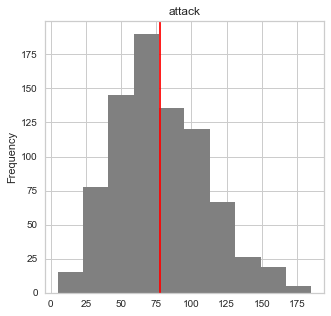

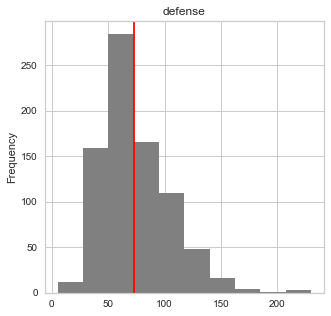

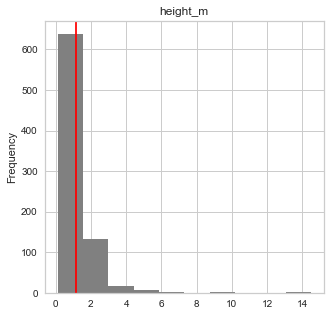

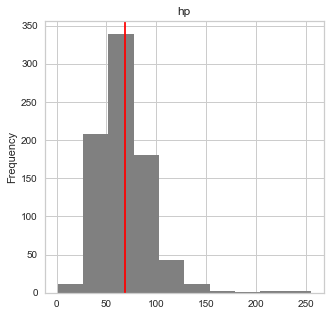

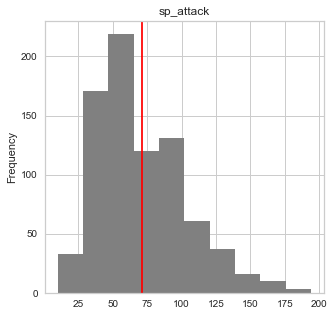

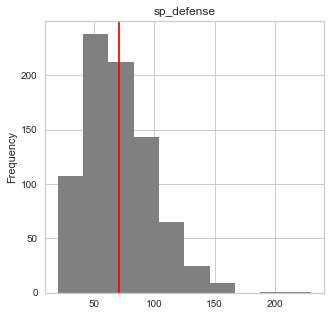

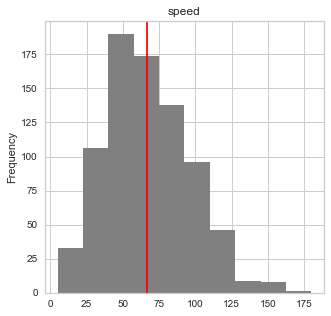

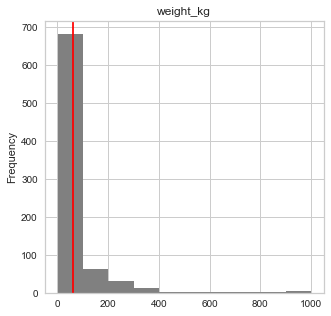

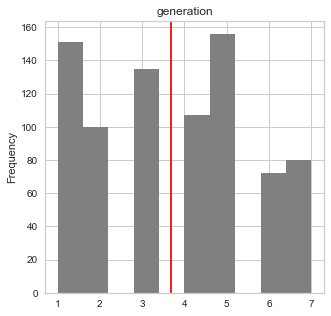

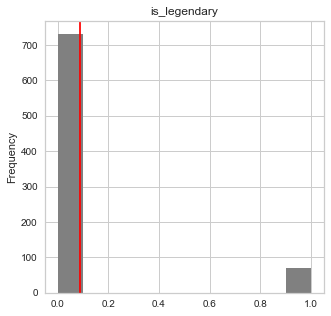

In [29]:
def generate_graphs(base):
    for col in base:
        if is_numeric_dtype(base[col]):
            plt.figure(col, figsize=(5, 5))
            plt.title(col)
            plt.axvline(base[col].mean(), color='red')
            base[col].plot(kind='hist', color='gray')
            

generate_graphs(data_pokemon)

Após a avaliação dos gráficos é possível perceber que a maioria deles é levemente assimetrico, no entanto, os outliers não vão prejudicar muito a leitura nesse caso. As únicas variáveis bruscamente assimetricas são as de peso e altura, assim, são criadas novas colunas com os valores logarítimicos de peso e altura

In [30]:
data_pokemon['log_weight'] = np.log(data_pokemon['weight_kg'])
data_pokemon['log_height'] = np.log(data_pokemon['height_m'])
#data_pokemon['log_def'] = np.log(data_pokemon['defense'])
#data_pokemon['log_hp'] = np.log(data_pokemon['hp'])
#Fiz essas duas últimas conversões e a distribuição não foi muito modificada, então as deixei de fora para facilitar a interpretação do modelo

<h3>2.  Estimando modelos de regressão linear</h3>

Com a base e as colunas devidamente ajustadas, é hora de começar a análise de regressão linear. Para ter uma ideia de quais variáveis podem ser interessantes na constituição do modelo, primeiro vou fazer um heatmap, mostrando as correlações entre todas as variáveis. Nesse mapa interessa saber as correlações entre a variável dependente (HP) e as demais

Text(0.5, 1.0, 'Correlação das variáveis entre status pokemon')

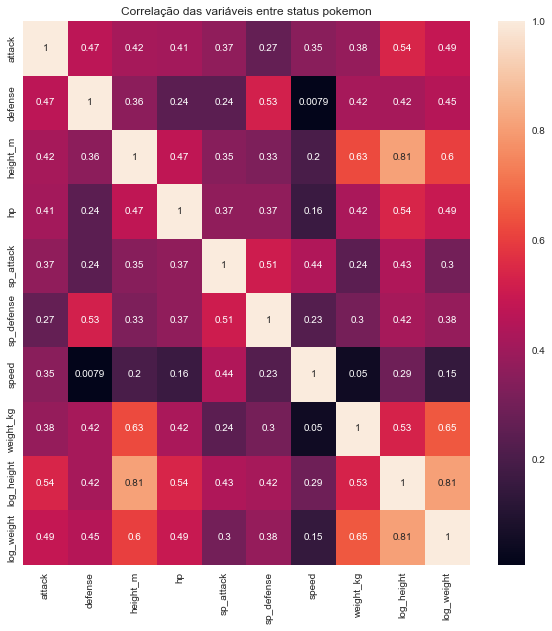

In [31]:
data_valores = data_pokemon[['attack', 'defense', 'height_m', 'hp', 'sp_attack', 'sp_defense', 'speed', 'weight_kg', 'log_height', 'log_weight']]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(data_valores.corr(), annot=True)
ax.set_title('Correlação das variáveis entre status pokemon')

O mapa aponta que a variável de HP possui uma boa correlação com a altura e o peso dos pokemons. Primeiro vou testar um modelo de regressão linear simples com o log da altura, já que essa variável é a que apresenta maior correlação com HP. 

In [32]:
x1 = data_pokemon['log_height'].values
y = data_pokemon['hp'].values

x1 = x1.reshape(-1, 1)
y = y.reshape(-1, 1)

regressao = LinearRegression()
modelo = regressao.fit(x1, y)

print('o intercepto do modelo é {} e o coeficiente é {}. Como a variável está em versão logaritima, o aumento de 1m na altura representa um aumento de {}% no hp do pokemon. Essa relação explica {}% variável dependente'.format(modelo.intercept_[0], modelo.coef_[0,0],((modelo.coef_[0,0])/100),((regressao.score(x1,y))*100)))
#modelo.coef_
#modelo.intercept_
#regressao.score(x1, y)

o intercepto do modelo é 71.07524814855421 e o coeficiente é 20.578435737436777. Como a variável está em versão logaritima, o aumento de 1m na altura representa um aumento de 0.20578435737436776% no hp do pokemon. Essa relação explica 29.218547156704034% variável dependente


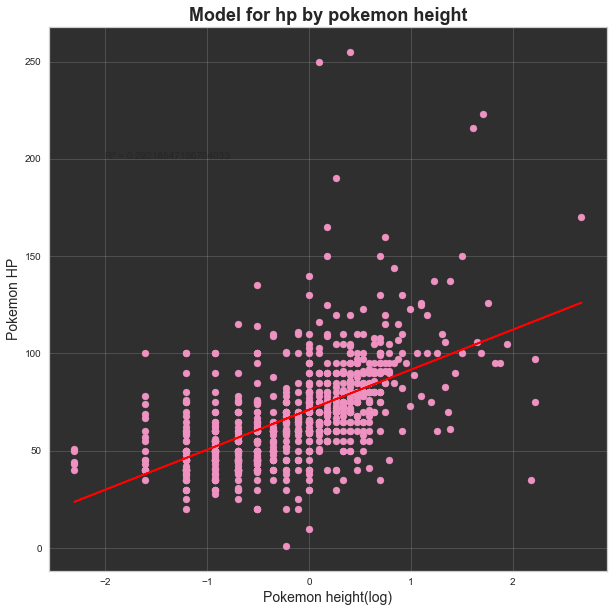

In [33]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Model for hp by pokemon height', fontdict={'size': 18, 'family':'sans-serif', 'weight':'bold'})
ax.set_ylabel('Pokemon HP', fontdict={'size': 14})
ax.set_xlabel('Pokemon height(log)', fontdict={'size': 14})
ax.set_facecolor('#2F2F2F')
ax.grid(alpha=0.2)
ax.annotate('R² = {}'.format(regressao.score(x1, y)), (-2,200))
plt.scatter(x1, y, color='#EE92C2')
plt.plot(x1, modelo.predict(x1), color='red')


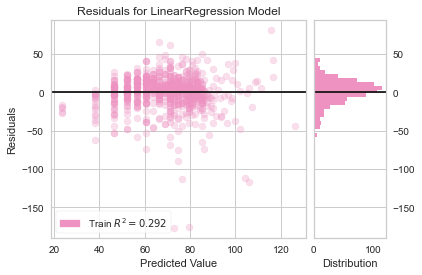

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [34]:
vresiduos = ResidualsPlot(modelo, train_alpha=0.3, train_color='#EE92C2')
vresiduos.fit(x1, y, figsize=(20,20))
vresiduos.poof()

Os gráficos mostram que a relação entre altura e HP obedece uma linearidade e que os outliers existentes estão localizados principalmente no eixo Y, em alturas de X com muitas observações, assim não enviesam o modelo. O gráfico de resíduos mostra uma distribuição normal entre esses.
É possível associar mais variáveis ao modelo de regressão linear para tentar encontrar uma relação maior entre a constituição do HP e outros índices para cada caso; colocarei o peso do pokemon e a variável categórica que pergunta se ele é lendário ou não.

In [35]:
x2 = data_pokemon[['log_height', 'log_weight']]
#x3 = data_pokemon['log_weight'].values
y2 = data_pokemon['hp']

#x2 = x2.reshape(-1, 1)
#x3 = x3.reshape(-1, 1)
regressao2 = LinearRegression()
modelo2 = regressao2.fit(x2, y2)

regressao2.score(x2, y2)

print('o intercepto do modelo é {}, os coeficientes b1 a b2 de altura e peso são {}. Como as variáveis estão em versão logaritima, o aumento de 1m na altura e 1kg no peso representam, respectivamente, um aumento {}% no hp do pokemon. Essa relação explica {}% da variável dependente'.format(modelo2.intercept_, modelo2.coef_,((modelo2.coef_)/100),((regressao2.score(x2,y))*100)))


o intercepto do modelo é 61.60810539000102, os coeficientes b1 a b2 de altura e peso são [15.55232078  2.8440903 ]. Como as variáveis estão em versão logaritima, o aumento de 1m na altura e 1kg no peso representam, respectivamente, um aumento [0.15552321 0.0284409 ]% no hp do pokemon. Essa relação explica 30.14659012945956% da variável dependente


O melhor modelo encontrado para o caso foi o do hp em função da altura e peso do pokemon, visto que tentativas com outras variáveis não aumentavam o R² da regressão de maneira significativa e apenas dificultavam a interpretação do modelo. Por último, ploto alguns gráficos referentes ao alinhamento da reta de regressão linear em relação aos valores previstos e ao conjunto dos resíduos

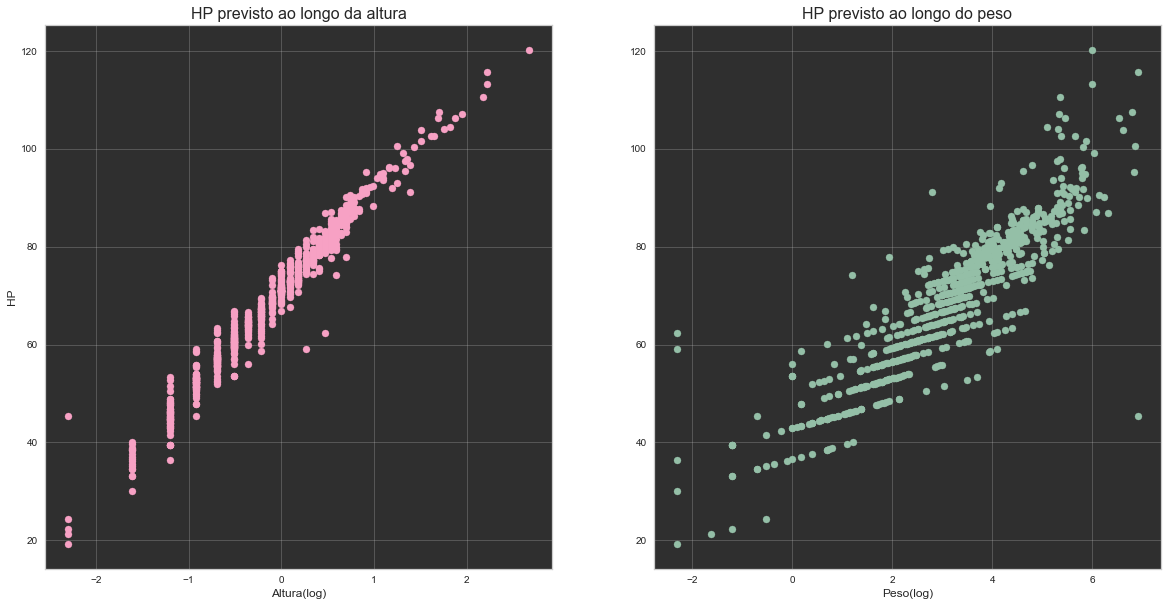

In [40]:
fig, ax2 = plt.subplots(1,2,figsize=(20,10))
height_scatter = ax2[0].scatter(x2.iloc[:,0], modelo2.predict(x2), color='#F7A1C4')
weight_scatter = ax2[1].scatter(x2.iloc[:,1], modelo2.predict(x2), color='#94BFA7')




#Mapa da esquerda
ax2[0].set_title('HP previsto ao longo da altura', fontdict={'size': 16})
ax2[0].set_ylabel('HP', fontdict={'size':12})
ax2[0].set_xlabel('Altura(log)', fontdict={'size':12})
ax2[0].set_facecolor('#2F2F2F')
ax2[0].grid(alpha=0.25)
#Mapa da direita
ax2[1].set_title('HP previsto ao longo do peso', fontdict={'size': 16})
ax2[1].set_xlabel('Peso(log)', fontdict={'size':12})
ax2[1].set_facecolor('#2F2F2F')
ax2[1].grid(alpha=0.25)


Assim, através do sklearn foi possível realizar o modelo de regressão múltipla. O modelo revelou uma correlação interessante, de aproximadamente 30%, entre o HP (os pontos de vida) de cada pokemon e suas alturas e pesos. É importante notar que o principal objetivo dessa biblioteca é a fixação do uso de modelos de regressão e, portanto, foi privilegiada uma base de uso mais simples e divertida de utilizar.

<h6> -   Adicionar plot de resíduos para regressão linear múltipla

-   Adicionar linhas da regressão linear múltipla</h6>